In [80]:
import pandas as pd
from pathlib import Path
import plotly.graph_objects as go
import plotly.subplots as ps

pd.set_option('display.max_rows', 4)

In [81]:
D_RESULTS = Path('../results/')

In [82]:
total_score_df = pd.DataFrame()

for directory in sorted(D_RESULTS.iterdir()):
    dirname = directory.name
    antigen_type = dirname.split(".", maxsplit=1)[0]
    if antigen_type == "His":
        results_tsv = directory / f"{dirname}.tsv"

        if ".AllCell" in dirname:
            histone_mark = dirname.split(".")[-2]
            cell_type_class = dirname.split(".")[-1]
            cell_type = ""
        else:
            histone_mark = dirname.split(".")[-3]
            cell_type_class = dirname.split(".")[-2]
            cell_type = dirname.split(".")[-1]

        score_df = (
            pd.read_table(results_tsv, header=[0, 1])
            .drop([0])
            .set_index(("data", "metric_type"))
            .rename_axis(index=None)
            .sort_index()
        )

        score_df.columns = pd.MultiIndex.from_tuples(
            [
                (
                    histone_mark,
                    cell_type_class,
                    cell_type,
                    f"<b>{histone_mark}</b>: {cell_type_class} - {cell_type}".strip(
                        " - "
                    ),
                    ".".join(tup[0].split(".")[-2:]),
                    tup[1],
                )
                for tup in score_df.columns
            ]
        )
        total_score_df = pd.concat([total_score_df, score_df], axis=1)

total_score_df = total_score_df.melt(
    var_name=[
        "histone_mark",
        "cell_class",
        "cell_type",
        "full_title",
        "transition",
        "metric",
    ],
    ignore_index=False,
).reset_index(names="method")

total_score_df = total_score_df[
    total_score_df["transition"].str.contains("mm10.hg38|hg38.mm10")
]
total_score_df['value'] /= 100
total_score_df


,method,histone_mark,cell_class,cell_type,full_title,transition,metric,value
30,adda,H2B,AllCell,,<b>H2B</b>: AllCell,hg38.mm10,accuracy,0.63980
31,afn,H2B,AllCell,,<b>H2B</b>: AllCell,hg38.mm10,accuracy,0.66941
...,...,...,...,...,...,...,...,...
4498,mdd,H3K9me3,Pluripotent_stem_cell,iPS_cells,<b>H3K9me3</b>: Pluripotent_stem_cell - iPS_cells,hg38.mm10,roc_auc,0.90400
4499,src_only,H3K9me3,Pluripotent_stem_cell,iPS_cells,<b>H3K9me3</b>: Pluripotent_stem_cell - iPS_cells,hg38.mm10,roc_auc,0.91528


In [83]:
total_score_df['cell_class'].unique()

array(['AllCell', 'Blood', 'Breast', 'Cardiovascular', 'Liver', 'Neural',
       'Pancreas', 'Pluripotent_stem_cell', 'Prostate', 'Lung'],
      dtype=object)

In [84]:
total_score_df[
    (total_score_df["histone_mark"] == "H3K27ac")
    & (total_score_df["cell_class"] == "Pancreas")
    & (total_score_df["cell_type"] == "Pancreatic_ductal_adenocarcinoma")
].to_csv('h3k27ac_pancreas.tsv', sep='\t', index=False)


In [85]:
method_to_symbol = {
    "adda": "square",
    "afn": "diamond",
    "cdan": "cross",
    "dan": "x",
    "dann": "triangle-up",
    "jan": "triangle-down",
    "mcc": "star",
    "mcd": "triangle-left",
    "mdd": "triangle-right",
    "src_only": "circle",
}
method_to_color = {
    "adda": "#7BD7F1",
    "afn": "#E27862",
    "cdan": "#F7D57E",
    "dan": "#75D1A9",
    "dann": "#F086A3",
    "jan": "#CAEB9E",
    "mcc": "#AF7DF4",
    "mcd": "#F3ABFA",
    "mdd": "#F4B37E",
    "src_only": "black",
}


title_filters = [
    "<b>H2B</b>: AllCell",
    "<b>H3K23ac</b>: AllCell",
    "<b>H3K36me1</b>: AllCell",
    "<b>H3K27ac</b>: Blood - Macrophages",
    "<b>H3K4me1</b>: Blood - Macrophages",
    "<b>H3K4me3</b>: Blood - Macrophages",
]


In [86]:
def plot_scatters(metric, titles, transitions, new_plotly_df, jitter, full_titles_order, methods, full_titles):
    n_rows = 2
    n_cols = 6
    fig = ps.make_subplots(
        rows=n_rows,
        cols=n_cols,
        shared_yaxes="rows",
        horizontal_spacing=0.01,
        vertical_spacing=0.03,
        column_titles=[x.replace(":", "<br>") for x in titles["full_title"].values],
        row_titles=transitions,
    )

    legend_method_ids = []
    for i, transition in enumerate(transitions):
        for j, full_title in enumerate(full_titles):
            df = new_plotly_df[
                (new_plotly_df["transition"] == transition)
                & (new_plotly_df["full_title"] == full_title)
            ]

            for idx, row in df.iterrows():
                showlegend = False
                if row["color"] != "lightgray" and row["method"] not in legend_method_ids:
                    legend_method_ids.append(row["method"])
                    showlegend = True
                elif row["color"] == "lightgray" and row["method"] not in legend_method_ids and i == (len(transitions) - 1) and j == (len(full_titles) - 1):
                    legend_method_ids.append(row["method"])
                    showlegend = True
                sub = go.Scatter(
                    x=[full_titles_order[row["full_title"]] + jitter[row["method"]]],
                    y=[row["value"]],
                    mode="markers",
                    name=row["method"].upper(),
                    marker=dict(
                        color=row["color"], symbol=row["symbol"], line_width=1, size=15
                    ),
                    showlegend=showlegend,
                    legendrank=methods.index(row["method"]),
                )
                if row["text"]:
                    fig.add_annotation(
                        x=full_titles_order[row["full_title"]] + jitter[row["method"]],
                        y=row["value"],
                        text=row["text"],
                        showarrow=True,
                        arrowhead=2,
                        ax=20,
                        ay=-20,
                        yshift=10,
                        xshift=5,
                        row=i + 1,
                        col=j + 1,
                    )
                fig.add_trace(sub, row=i + 1, col=j + 1)
            fig.update_xaxes(ticks="", row=i + 1, col=j + 1)

    fig.update_xaxes(
        showticklabels=False, showline=True, linewidth=1, linecolor="black", mirror=True
    )

    fig.update_yaxes(
        ticks="",
        zeroline=True,
        zerolinecolor="gray",
        showline=True,
        linewidth=1,
        linecolor="black",
        mirror=True,
        # tickformat="+.2",
        showgrid=True,
    )
    fig.update_yaxes(ticks="outside", row=1, col=1)
    fig.update_yaxes(ticks="outside", row=2, col=1)

    fig.update_annotations(textangle=0, font=dict(size=16), align="center")
    fig.for_each_annotation(lambda a: a.update(y = 1.01) if a.text in [x.replace(":", "<br>") for x in titles["full_title"].values] else a.update(x = -.13) if a.text in transitions else())

    height=400 * len(transitions)
    width=300 * len(titles)
    # metric_str = metric.replace("accuracy", "Accuracy").replace("pr_auc", "PR AUC").replace("roc_auc", "ROC AUC")
    fig.update_layout(
        # title = f"<b>{metric_str}</b> score gains in <b>histone mark</b> predictions for each domain adaptation method in comparison with the source-only trained model",
        # title_x=0,
        # title_y=.98,
        height=height,
        width=width,
        font=dict(size=16),
        # uniformtext_minsize=16,
        margin=dict(l=225, t=75, b=50, r=25),
        legend=dict(
            # font_size=12,
            orientation="h",
            yanchor="bottom",
            y=-0.075,
            xanchor="right",
            x=0.98,
        ),
        template="simple_white",
    )
    fig.write_image(f"./img/six_histones_scatter_{metric}.png", scale=4)

    print(f"{height}x{width}")
    fig.show(renderer="png")

800x1800


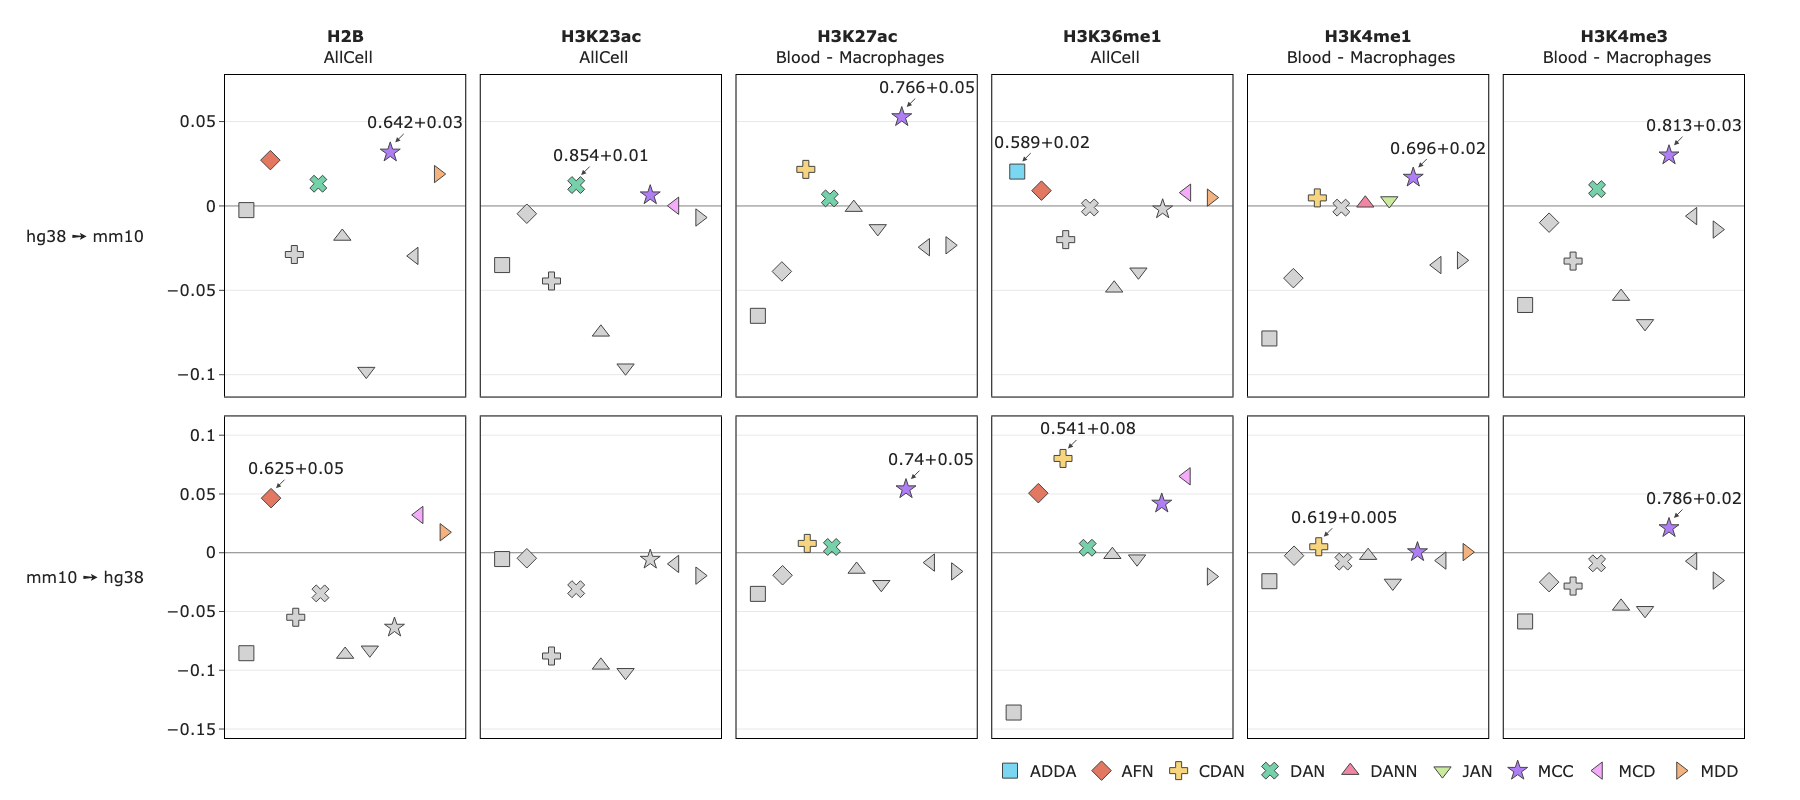

800x1800


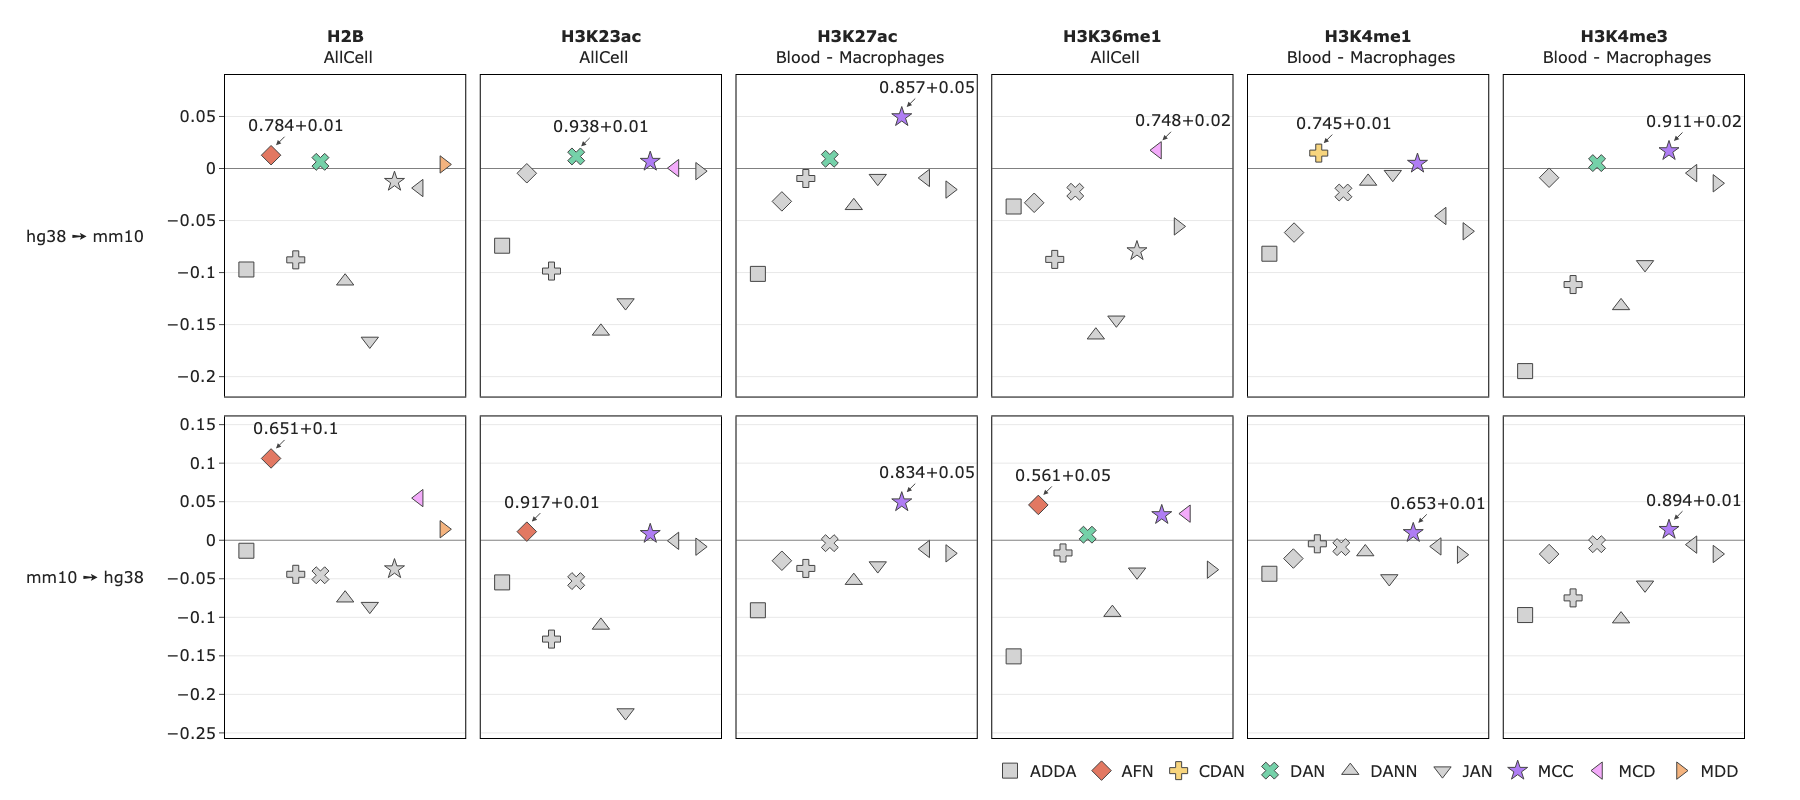

800x1800


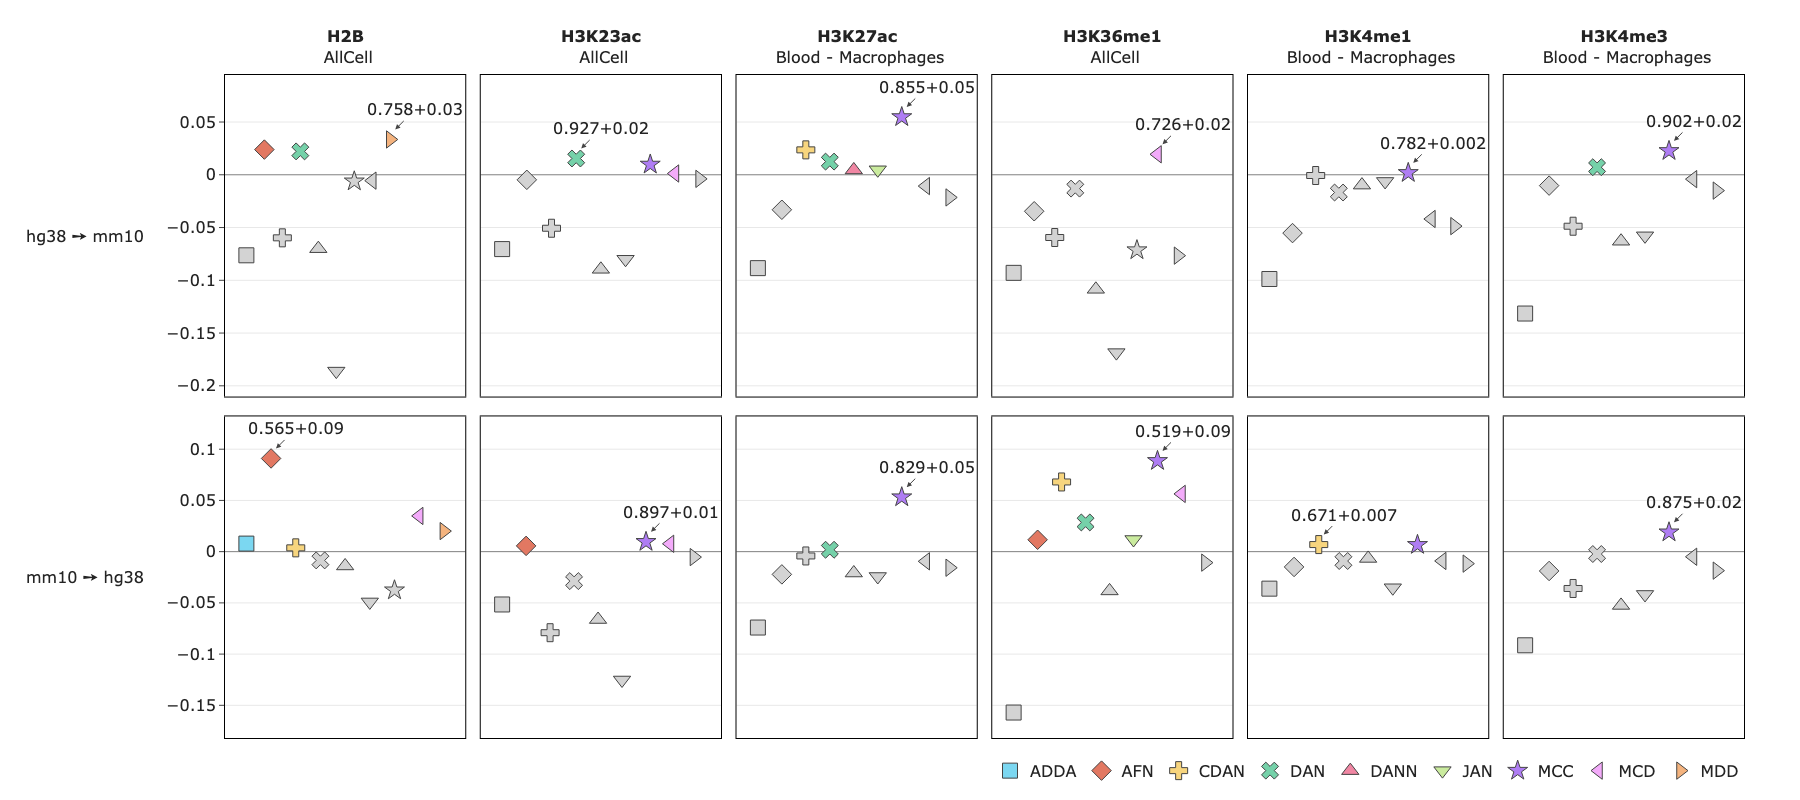

In [87]:
for metric in ["accuracy", "pr_auc", "roc_auc"]:
    plotly_df = total_score_df[
        (total_score_df["full_title"].isin(title_filters))
        & (total_score_df["metric"] == metric)
    ]
    new_plotly_df = pd.DataFrame()
    for idx, group in plotly_df.groupby(
        [
            "histone_mark",
            "cell_class",
            "cell_type",
            "transition",
            "metric",
        ]
    ):
        src_only = group[group["method"] == "src_only"]["value"].values[0]
        group = group.assign(
            symbol = group["method"].map(method_to_symbol),
            color = group["method"].map(method_to_color),
            transition = group["transition"].str.replace('.', ' ➙ ', regex=False),
            text = [f"{src_only:.3g}+{x - src_only:.1g}" if x == group["value"].max() else "" for x in group['value']],
        )
        group.loc[group["value"] < src_only, "color"] = "lightgray"
        group['value'] -= src_only
        group = group[group["method"] != "src_only"]
        new_plotly_df = pd.concat([new_plotly_df, group])
    
    titles = new_plotly_df[
        ["histone_mark", "cell_class", "cell_type", "full_title"]
    ].drop_duplicates()
    full_titles = titles["full_title"].values
    full_titles_order = {full_titles[i]: i for i in range(len(full_titles))}

    transitions = sorted(new_plotly_df["transition"].unique())
    methods = sorted(new_plotly_df["method"].unique())

    jitter = {methods[i]: (i - round(len(methods) / 2)) / 20 for i in range(len(methods))}

    plot_scatters(metric, titles, transitions, new_plotly_df, jitter, full_titles_order, methods, full_titles)
